<h1 align="center">Topic modeling on Medium articles</h1>

In [1]:
## All minimum setup and libraries required

import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## TENSORFLOW        
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer   ## Generate dictionary of word encodings
from tensorflow.keras.preprocessing.sequence import pad_sequences

## GENSIM and NLTK
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')

# SKLEARN
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

print("Tensorflow\t-\t",tf.__version__)
print("NLTK\t\t-\t",nltk.__version__)
print("Gensim\t\t-\t",nltk.__version__)

/kaggle/input/medium-articles-with-content/Medium_AggregatedData.csv
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Tensorflow	-	 2.3.0
NLTK		-	 3.2.4
Gensim		-	 3.2.4


In [2]:
path = "../input/medium-articles-with-content/Medium_AggregatedData.csv"
dataframe_full = pd.read_csv(path)
dataframe_imp = pd.read_csv(path)
print("Dataset have been read")

Dataset have been read


In [3]:
dataframe_full.head()

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,...,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [4]:
x = dataframe_full['name'][10]
y = dataframe_full['publicationdescription'][15]
print(x)
print(y)
print(dataframe_full.shape)
print(dataframe_full['name'][10])
print(dataframe_full['name'][11])
print(dataframe_full['name'][12])
print(dataframe_full['title'][10])

Big Data Training Mumbai
Non-obvious meditation advice from people on the battlefront of daily creation
(279577, 50)
Big Data Training Mumbai
Robotics
Meditation
Ascent of data Science, SAS and Big data Analyst Trainings Programs


# Step_1: Preprocessing and cleaning

**There are ~300000 entries**

In [5]:
print(dataframe_full.columns)

Index(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
       'collectionId', 'createdDate', 'createdDatetime', 'firstPublishedDate',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'language', 'latestPublishedDate', 'latestPublishedDatetime',
       'linksCount', 'postId', 'readingTime', 'recommends',
       'responsesCreatedCount', 'socialRecommendsCount', 'subTitle',
       'tagsCount', 'text', 'title', 'totalClapCount', 'uniqueSlug',
       'updatedDate', 'updatedDatetime', 'url', 'vote', 'wordCount',
       'publicationdescription', 'publicationdomain',
       'publicationfacebookPageName', 'publicationfollowerCount',
       'publicationname', 'publicationpublicEmail', 'publicationslug',
       'publicationtags', 'publicationtwitterUsername', 'tag_name', 'slug',
       'name', 'postCount', 'author', 'bio', 'userId', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'],
      dtype='object')


The required columns are:
* language
* subTitle
* tagsCount
* text
* title
* url
* wordCount
* publicationdescription
* tag_name
* name

but the most important columns are primarily:
* subTitle
* text
* title

In [6]:
required_col = ['language','subTitle','tagsCount','text','title','url','wordCount','publicationdescription'
               ,'tag_name','name']
most_imp_col = ['subTitle','text','title']

In [7]:
# article_titles = dataframe_full['title']
# art_grp_1 = article_titles[16:25]
# print(art_grp_1)
print(dataframe_full.language.unique())

['en' 'th' 'ja' 'zh' 'ru' 'pt' 'es' 'zh-Hant' 'id' 'my' 'de' 'tr' 'fr'
 'ko' 'it' 'lo' 'un' 'vi' 'cs' 'sk' 'is' 'sv' 'bn' 'mn' 'da' 'no' 'bg'
 'ar' 'pl' 'nl' 'ro' 'ca' 'hu' 'hi' 'ka' 'el' 'ms' 'uk' 'si' 'sr' 'lt'
 'la' 'fa' 'ml' 'sl' 'mr' 'az' 'lv' 'te' 'mk' 'nn' 'fi']


In [8]:
## Number of rows english rows

english_titles = dataframe_full[dataframe_full['language'] == 'en']
# english_titles.head()
print(english_titles.shape)

(257655, 50)


In [9]:
## Number of rows dropped after removing null value rows

print(dataframe_imp.shape)
dataframe_imp.dropna(how = 'all')
print(dataframe_imp.shape)

(279577, 50)
(279577, 50)


So nothing is missing in any rows

In [10]:
## After dropping non-english and columns that are not required really

dataframe_imp.drop(dataframe_imp[dataframe_imp['language'] != 'en'].index, inplace = True)

dataframe_imp = dataframe_imp.drop(['audioVersionDurationSec', 'codeBlock', 'codeBlockCount',
       'collectionId', 'createdDate', 'createdDatetime', 'firstPublishedDate',
       'firstPublishedDatetime', 'imageCount', 'isSubscriptionLocked',
       'language', 'latestPublishedDate', 'latestPublishedDatetime',
       'linksCount', 'postId', 'readingTime', 'recommends',
       'responsesCreatedCount', 'socialRecommendsCount','tagsCount','totalClapCount', 'uniqueSlug',
       'updatedDate', 'updatedDatetime', 'url', 'vote', 'wordCount',
       'publicationdescription', 'publicationdomain',
       'publicationfacebookPageName', 'publicationfollowerCount',
       'publicationname', 'publicationpublicEmail', 'publicationslug',
       'publicationtags', 'publicationtwitterUsername', 'tag_name', 'slug',
       'name', 'postCount', 'author', 'bio', 'userId', 'userName',
       'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'], axis=1)

dataframe_imp['index'] = dataframe_imp.index

dataframe_imp.shape

(257655, 4)

### Reduced dataset with 3col and ~20000 rows for reff.
Run these cells only to produce the reduced and compact dataset

In [11]:
## Run these cell to export the new trimmed down dataset

# dataframe_imp.to_csv("medium_dataset.csv",sep=",")
# new_ds_size = os.stat("medium_dataset.csv").st_size
# new_ds_size = new_ds_size / 1000000
# print("New dataset size in MB = ",new_ds_size)

***Choose one among the two in the cell below***

In [12]:
## Keeping 170000 rows greatly reduces the dataset size to around 100MB

very_reduced_dataset = dataframe_imp[:17000]
# very_reduced_dataset.to_csv("very_reduced_dataset.csv",sep=",")
# print("New dataset size in MB = ",os.stat("very_reduced_dataset.csv").st_size / 1000000)

# from IPython.display import FileLink
# FileLink(r'very_reduced_dataset.csv')

In [13]:
dataframe_imp.head()

,subTitle,text,title,index
0,A major private IT company implements blockcha...,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",0
1,A major private IT company implements blockcha...,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",1
2,A major private IT company implements blockcha...,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",2
3,Introduction,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),3
4,Introduction,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),4


In [14]:
print(dataframe_imp.title[15])
print(dataframe_imp.subTitle[15])
# print(dataframe_imp.text[15])      ## Text is too huge to be displayed
print(dataframe_imp.index[15])

Can a robot love us better than another human can?
I discussed this with Michelle Tsng on my Podcast “Crazy Wisdom”.
15


**after dropping all the non english rows and after dropping all non essential columns `dataframe_imp` is the required dataframe****

### Perform lemmatization and stem preprocessing steps on the data set

In [15]:
## Stemmer initialization for english
stemmer = SnowballStemmer("english")

In [16]:
## Functions for lemmatization, removal of Stopwords

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [17]:
### Code to check the function

## Run this for faster execution time wiht less acuracy
doc_sample = very_reduced_dataset[very_reduced_dataset['index'] == 1000].values[0][2]

## Run this for slower execution but better accuracy
# doc_sample = dataframe_imp[dataframe_imp['index'] == 1000].values[0][2]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
    
print(dataframe_imp[dataframe_imp['index'] == 1000].values[0][2])
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
Machine Learning Made Easy: What it is and How it Works
['Machine', 'Learning', 'Made', 'Easy:', 'What', 'it', 'is', 'and', 'How', 'it', 'Works']


 tokenized and lemmatized document: 
['machin', 'learn', 'easi', 'work']


### Processed titles

In [18]:
## Use this to reduce the training time at the cost of loss of rows and some accuracy.
title_list = very_reduced_dataset['title'].astype(str)

## Use this for higher model accuracy but very slow operating time. 
# title_list = dataframe_imp['title'].astype(str)   ## using astype(str) eliminates the floting type error
title_list.describe()

count                           17000
unique                           4436
top       10 new things to read in AI
freq                               24
Name: title, dtype: object

In [19]:
## The titles are preprocessed and saved into processd_titles
## The map function applies the preprocess method on each of the list entries

processed_titles = title_list.map(preprocess)
processed_titles[30:40]

34    [meta, model, meta, meta, model, deep, learn]
35    [meta, model, meta, meta, model, deep, learn]
36               [tip, data, scienc, team, succeed]
37               [tip, data, scienc, team, succeed]
38               [tip, data, scienc, team, succeed]
39                                   [trust, trust]
40                                   [trust, trust]
41                                   [trust, trust]
42                                   [trust, trust]
43                                   [trust, trust]
Name: title, dtype: object

# Step_2: Creation of the Bag of words
Bag of words is a frequency count of the words occuring in the `preprocessed_docs`

In [20]:
## bow --> Bag of Words

bow = gensim.corpora.Dictionary(processed_titles)

## Finding out words with a min_occurance = 10

min_occurance = 10
count = 0
for k, v in bow.iteritems():
    print(k, v)
    count += 1
    if count > min_occurance:    # We can limit the selection based on the frequency
        break

0 blockchain
1 busi
2 govern
3 privat
4 draft
5 word
6 analyst
7 ascent
8 data
9 program
10 scienc


### Filtering tokens based on
* less than 15 occurances in titles
* more than 0.5 of total titles
* after the above two steps, keep only the first 100000 most frequent tokens.


In [21]:
bow.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print(bow)

Dictionary(932 unique tokens: ['blockchain', 'busi', 'govern', 'privat', 'draft']...)


### Generating the doc2bow dictionary

For each title we create a dictionary reporting how many words and how many times those words appear. This is saved to the `bow_corpus`.

##### **NOTE:** This step gives a simmillar result for a very small corpus such as title of the articles, but it is important while working on the actual body of the articles.

In [22]:
bow_corpus = [bow.doc2bow(doc) for doc in processed_titles]
bow_corpus[:10]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (5, 1)],
 [(6, 1), (7, 2), (8, 1), (9, 1), (10, 1)],
 [(6, 1), (7, 2), (8, 1), (9, 1), (10, 1)],
 [(6, 1), (7, 2), (8, 1), (9, 1), (10, 1)]]

### Preview of the BOW for the preprocessed titles

In [23]:
## A example of the BOW for the 1000th title

bow_example = bow_corpus[1000]
for i in range(len(bow_example)):
    print("Word {} (\"{}\") appears {} time.".format(bow_example[i][0], 
           bow[bow_example[i][0]], 
           bow_example[i][1]))

Word 101 ("fake") appears 1 time.
Word 228 ("photo") appears 1 time.
Word 419 ("believ") appears 1 time.
Word 420 ("game") appears 1 time.
Word 421 ("generat") appears 1 time.


# Step_3: TF-IDF 
TF-IDF stands for ***term frequency–inverse document frequency***. The higher the TF-IDF score the rarer a word is in a given corpus and vice-versa. We will be using the TF-IDF model for the gensim models library.

In [24]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# from pprint import pprint

for i in corpus_tfidf:
    print(i)
    break

[(0, 0.37967924604419184), (1, 0.38510895463809597), (2, 0.5734341889792183), (3, 0.6153925528397408)]


# Step_4: Running LDA algo on the bag of words
Testing LDA(Latent Dirichlet allocation) on the BOW. We will be training our LDA model using `gensim.models.LdaMulticore` and save it to `lda_model`

### Creating the base model

In [25]:
## LDA when the num_topics = 10

# lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=bow, passes=5, workers=3)
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=bow,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
print(lda_model)
# For optimal performance time set the workers as no of CPU cores-1

LdaModel(num_terms=932, num_topics=10, decay=0.5, chunksize=100)


**For each topic, we will explore the words occuring in that topic and its relative weight.**

### Topic distribution generated by the model

In [26]:
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))
doc_lda = lda_model[bow_corpus]


Topic: 0 
Words: 0.047*"digit" + 0.044*"manag" + 0.041*"classif" + 0.040*"time" + 0.039*"know" + 0.036*"think" + 0.036*"scientist" + 0.033*"transform" + 0.031*"engin" + 0.029*"real"

Topic: 1 
Words: 0.053*"work" + 0.051*"python" + 0.040*"experi" + 0.039*"autom" + 0.037*"custom" + 0.031*"meet" + 0.030*"improv" + 0.029*"talk" + 0.028*"team" + 0.027*"better"

Topic: 2 
Words: 0.071*"network" + 0.053*"neural" + 0.046*"market" + 0.039*"build" + 0.038*"news" + 0.035*"chang" + 0.035*"realiti" + 0.034*"algorithm" + 0.033*"help" + 0.029*"tech"

Topic: 3 
Words: 0.174*"intellig" + 0.159*"artifici" + 0.059*"technolog" + 0.037*"blockchain" + 0.026*"understand" + 0.023*"chatbot" + 0.020*"tool" + 0.018*"research" + 0.017*"generat" + 0.017*"educ"

Topic: 4 
Words: 0.096*"human" + 0.066*"robot" + 0.051*"week" + 0.046*"imag" + 0.041*"read" + 0.032*"languag" + 0.031*"product" + 0.029*"process" + 0.025*"natur" + 0.023*"kera"

Topic: 5 
Words: 0.052*"busi" + 0.047*"power" + 0.046*"thing" + 0.041*"predic

In [27]:
topics = lda_model.show_topics(formatted=False)
topic_words = dict(topics[1][1])
print("For topic 1, the words are: ",topic_words)

For topic 1, the words are:  {'work': 0.052633855, 'python': 0.050825153, 'experi': 0.040364638, 'autom': 0.039445028, 'custom': 0.037277192, 'meet': 0.031252824, 'improv': 0.03010906, 'talk': 0.028542288, 'team': 0.0282307, 'better': 0.026819248}


<h3 style="color:blue;">Here each topic can be visualized as recipie of the probability of the words that can appear in it.</h3>In geometry, a simplex is a generalization of the notion of a triangle or tetrahedron to arbitrary dimensions [source] (https://en.wikipedia.org/wiki/Simplex). LDA space is a simplex since we are dealing wiht probability distributions here. Dimensionality of the space depends on the number of topics we ask the model to make.

# Step_5: Visualization 
1. Topic modeling with LDA
2. Visualizing topic models with pyLDAvis
3. Visualizing LDA results with t-SNE and bokeh

In [28]:
%pylab inline

import pandas as pd
import pickle as pk
from scipy import sparse as sp

Populating the interactive namespace from numpy and matplotlib


## Wordcloud of Top N words in each topic

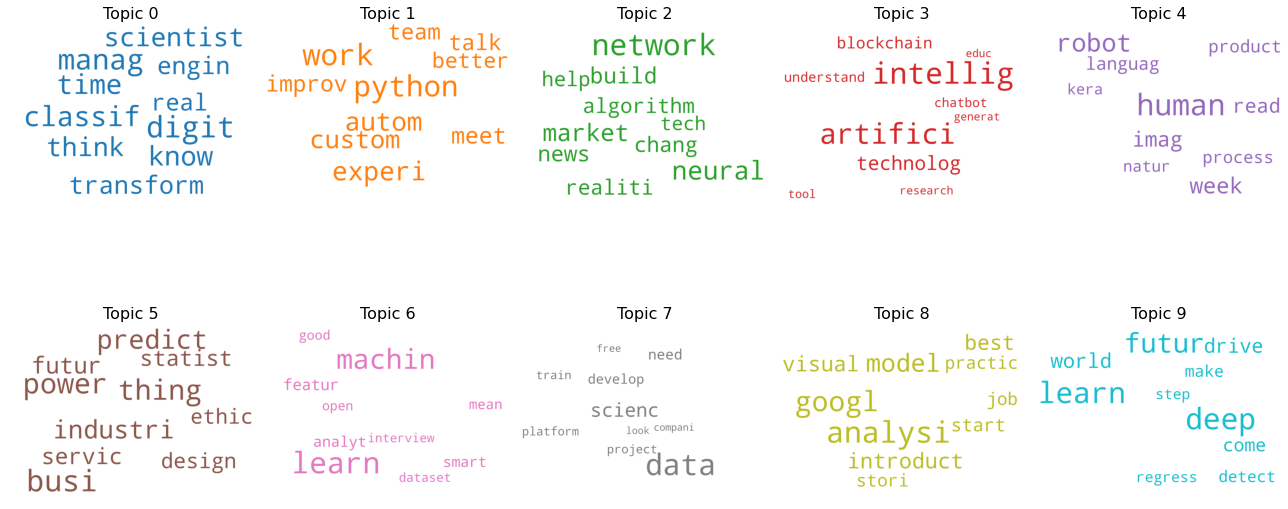

In [61]:
## Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(18,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word count vs Weights of topics

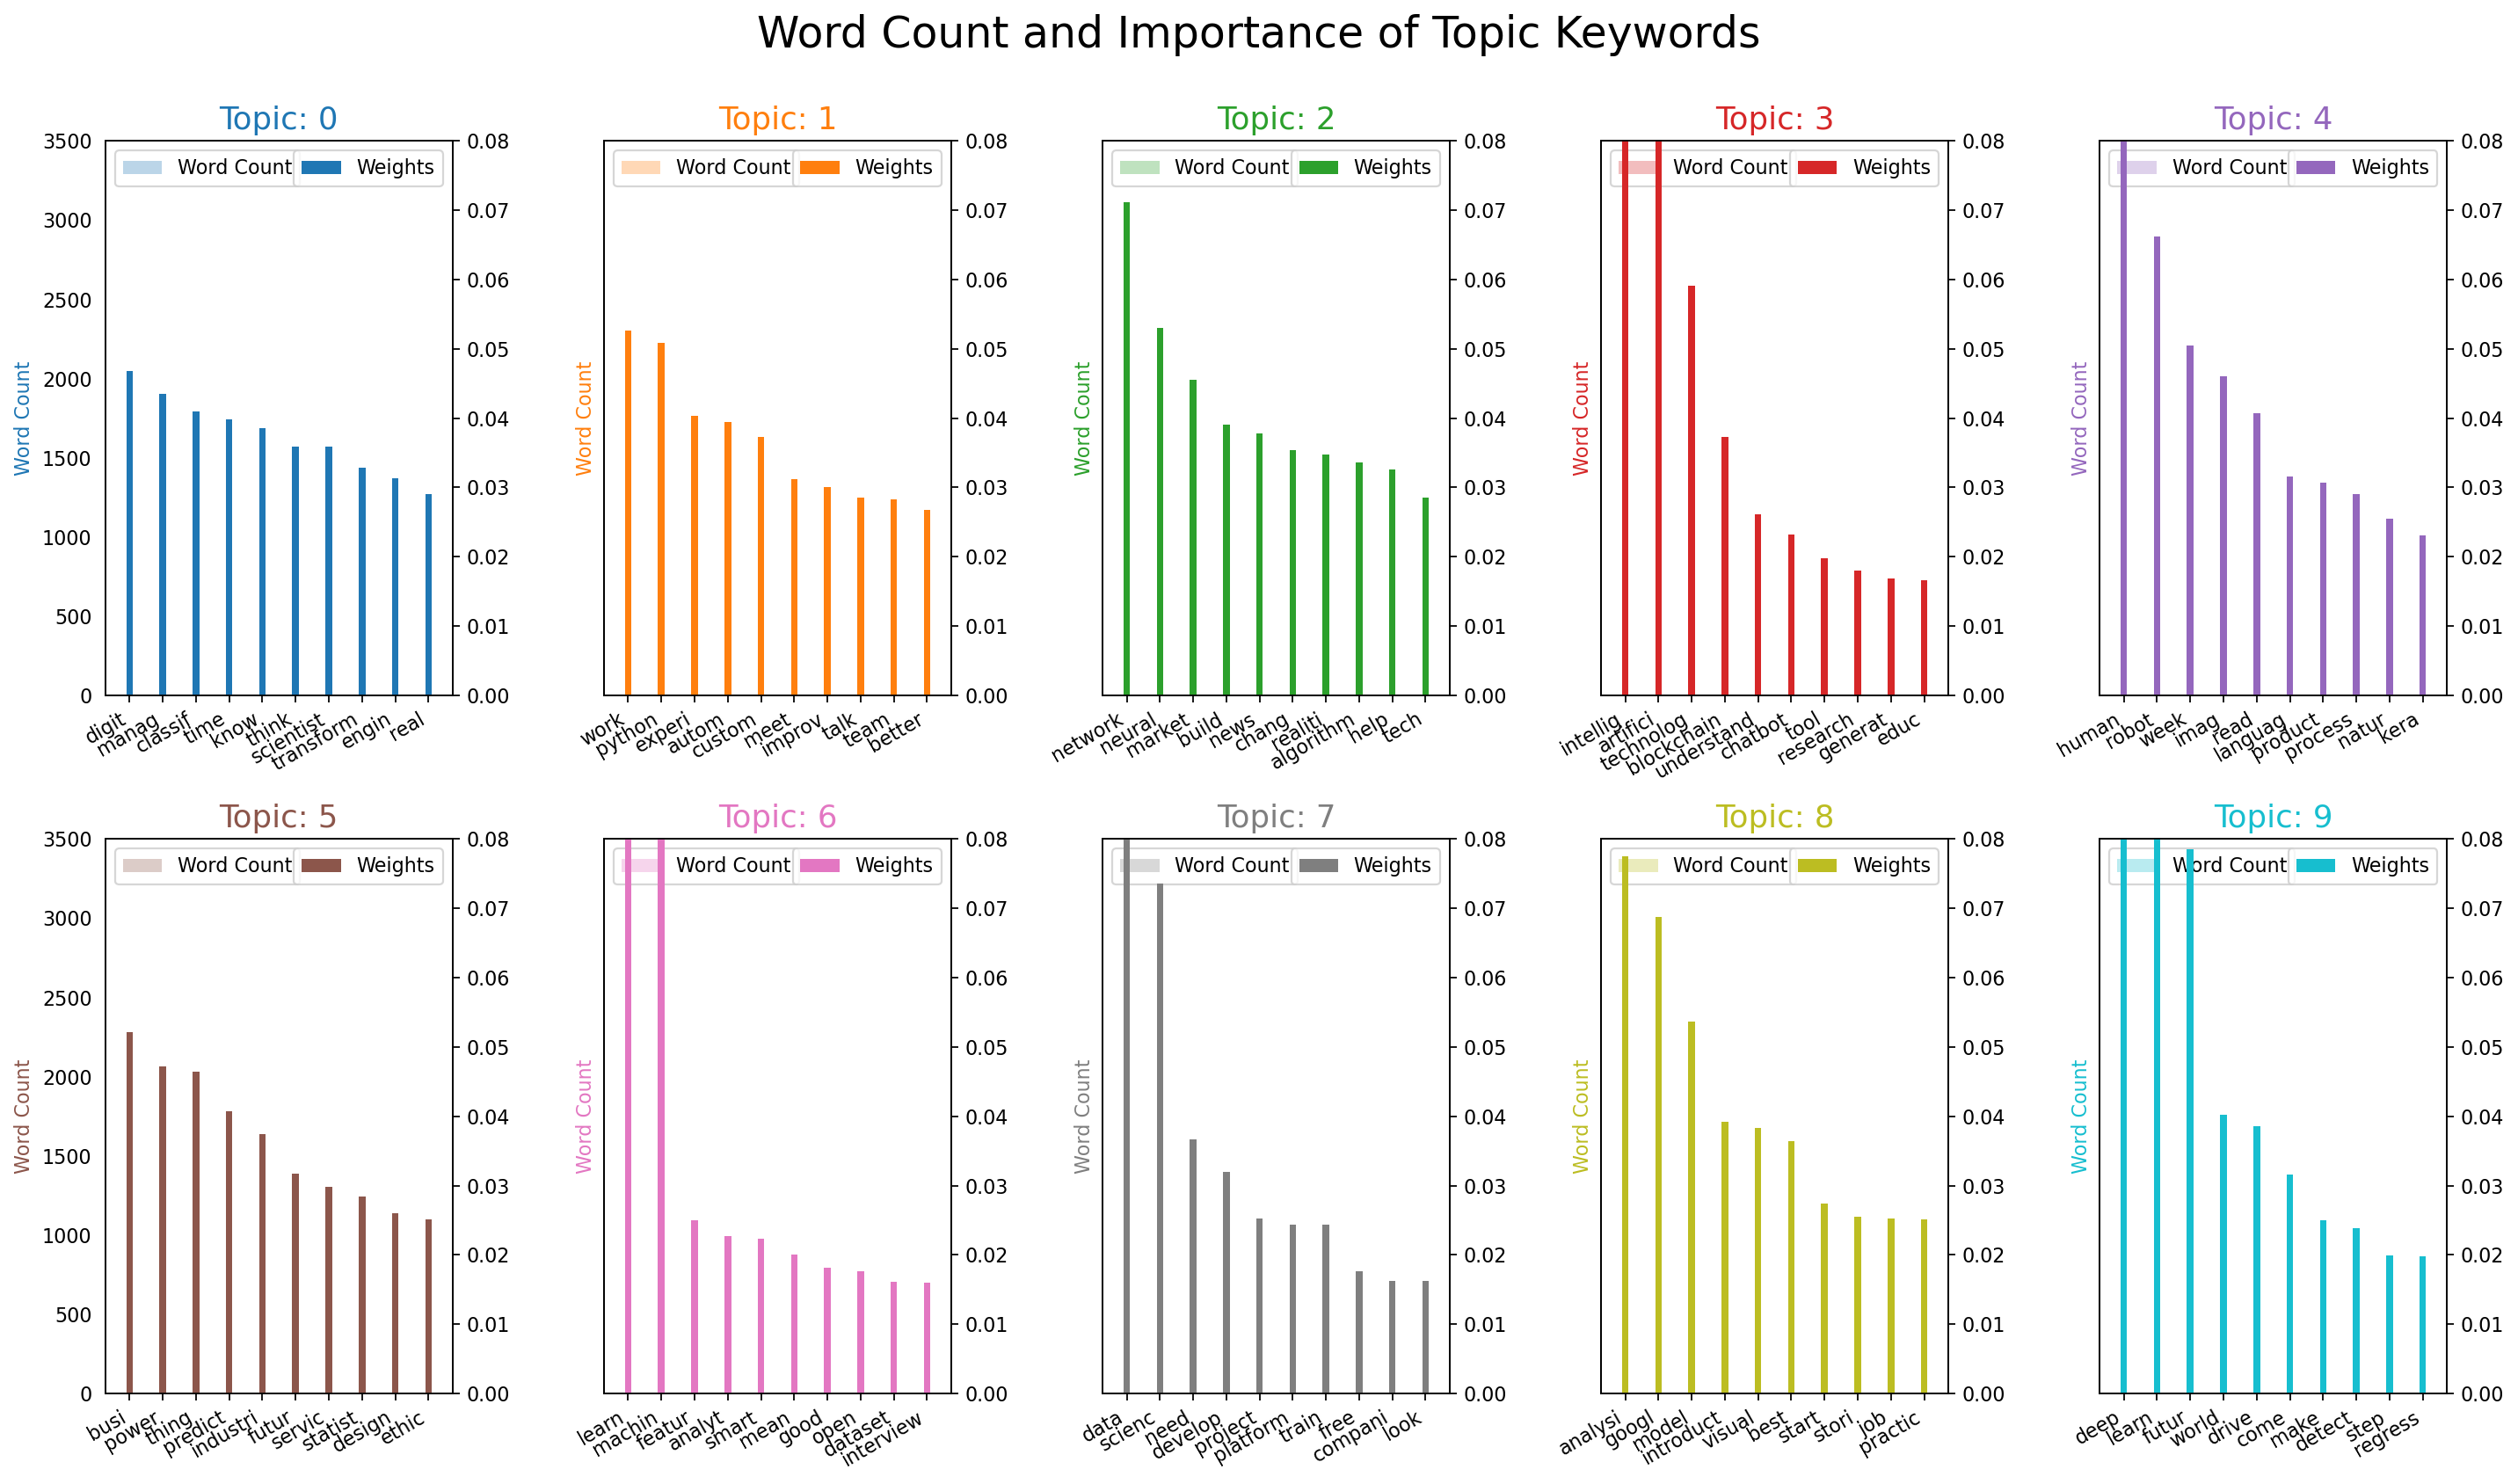

In [62]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in dataframe_imp for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 5, figsize=(18,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.08); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [31]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.117476 -0.188994       1        1  13.034580
3     -0.057776  0.295604       2        1  12.748475
6      0.313105  0.003252       3        1  11.334051
9      0.315371  0.017457       4        1  10.377987
2     -0.104585 -0.244449       5        1   9.340352
5      0.073942 -0.132645       6        1   9.193499
4     -0.128433 -0.002293       7        1   8.825508
0     -0.083149  0.026118       8        1   8.553819
1     -0.119774  0.172175       9        1   8.506526
8     -0.091224  0.053776      10        1   8.085201, topic_info=         Term         Freq        Total Category  logprob  loglift
7        data  1823.000000  1823.000000  Default  30.0000  30.0000
21      learn  2005.000000  2005.000000  Default  29.0000  29.0000
41     machin  1250.000000  1250.000000  Default  28.0000  28.0000
18   intellig  1251.000000  1251.000000  Default  27.0000  27.0000
16   artifici  1140.000000  1140.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
178     great    45.505302    46.399033  Topic10  -4.6038   2.4957
153      appl    43.371174    44.264836  Topic10  -4.6518   2.4947
536    select    43.047895    43.941717  Topic10  -4.6593   2.4946
888    letter    41.850344    42.744082  Topic10  -4.6875   2.4940
334      self    52.691785    98.891215  Topic10  -4.4571   1.8856

[352 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
822       6  0.983071     advanc
834       4  0.988821    advisor
79        5  0.993214  algorithm
159      10  0.983130     amazon
180       2  0.002819    analysi
...     ...       ...        ...
746       1  0.984467   workflow
921       6  0.986117   workplac
24        4  0.994677      world
113       5  0.980867      write
444       9  0.990605       year

[328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 7, 10, 3, 6, 5, 1, 2, 9])

# Step_6: Coherence score (base model)
> ****Topic Coherence**** measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

> A set of statements or facts is said to be ****coherent****, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

## Using c_v measure

In [35]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_titles, dictionary=lda_model.id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6199787863209474


## Using UMass Measure

In [36]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_titles, dictionary=lda_model.id2word, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -17.476265762251685


These are the base scores for the default model

# Step_6: Hyperparameter tuning
The model hyperparameters to be determined are:
* num_topics (k)
* alpha (document density)
* beta (Word-Topic Density)

In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit,cs_type, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=cs_type)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### CASE_1: With c_v coherence score and num_topics

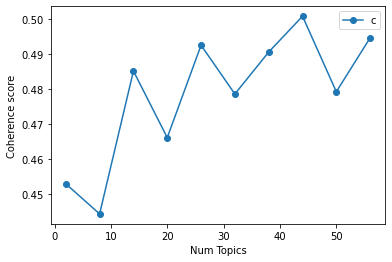

In [38]:
model_list, coherence_values = compute_coherence_values(dictionary=bow, corpus=bow_corpus, texts=processed_titles, start=2, limit=60, step=6,cs_type = 'c_v')
# Show graph
import matplotlib.pyplot as plt
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

From the above plot it is evident that coherence score increases
with respect to the `num_topics` till it reaches somewhere
between 40 to 50 and declines thereafter. A `num_topics` value of 44
will have a good coherence score

### CASE_2: With u_mass coherence score and num_topics

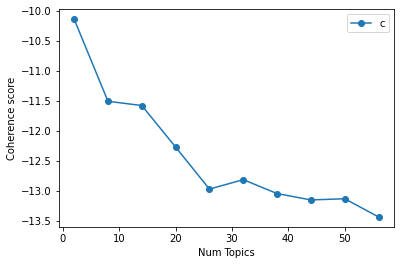

In [39]:
model_list, coherence_values = compute_coherence_values(dictionary=bow, corpus=bow_corpus, texts=processed_titles, start=2, limit=60, step=6,cs_type = 'u_mass')
# Show graph
import matplotlib.pyplot as plt
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values,marker = 'o')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Grid search on the three hyper parameters wrt c_v Coherence score

In [40]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=bow,
                                           num_topics=45, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_titles, dictionary=lda_model.id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [41]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
alpha = np.array([0.05,0.1,0.5,1,5,10])
# alpha.append('symmetric')
# alpha.append('asymmetric')

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
beta = np.array([0.05,0.1,0.5,1,5,10])
# beta.append('symmetric')

# Validation sets
num_of_docs = len(bow_corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(bow_corpus, int(num_of_docs*0.75)), 
               bow_corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
k = 45
# Can take a long time to run
# if 1 == 1:
pbar = tqdm.tqdm(total=200, position=0, leave=True)


# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=lda_model.id2word, 
                                          k=k, a=a, b=b)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)
            pbar.update(1)
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
pbar.close()

 36%|███▌      | 72/200 [24:43<43:58, 20.61s/it]  


In [42]:
dataframe_results = pd.read_csv("./lda_tuning_results.csv")
dataframe_results
topics = dataframe_results['Topics']
coherence_values = dataframe_results['Coherence']
dataframe_results['Topics'].unique()

array([45])

In [52]:
optimal = dataframe_results[dataframe_results['Validation_Set'] == '100% Corpus']
max_coherence_val = optimal['Coherence'].max()
optimal = dataframe_results[dataframe_results['Coherence'] == max_coherence_val]
print(optimal)
# print(val_set)

   Validation_Set  Topics  Alpha  Beta  Coherence
55    100% Corpus      45    1.0   0.1    0.63341


#### The row with the max Coherence Score(c_v) of 0.63341 has `beta = 0.1` and `alpha = 1.0`

# Step_7: Final Model
The row with the max Coherence Score(c_v) of 0.631025 has `beta = 0.1` and `alpha = 1.0`
Now training the new model with these values

In [53]:
final_lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                             id2word=bow,
                                             num_topics=45,
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha = 1.0,
                                             eta=0.1, 
                                             per_word_topics=True)

In [54]:
final_coherence_model_lda = CoherenceModel(model=final_lda_model, texts=processed_titles, dictionary=lda_model.id2word, coherence='c_v')
final_coherence_score = final_coherence_model_lda.get_coherence()
print('\nCoherence Score: ',final_coherence_score )


Coherence Score:  0.6301514801325928


There is a little improvement of the coherence score of the final model over the base model

### LDA visualization on the final model

In [57]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(final_lda_model, bow_corpus, dictionary=bow)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.054435  0.059839       1        1  2.486787
22     0.262926  0.076260       2        1  2.429446
14    -0.005968 -0.354437       3        1  2.372461
19    -0.041098 -0.114807       4        1  2.307931
10     0.351547  0.060989       5        1  2.300332
27     0.301711  0.074376       6        1  2.293546
30    -0.055846  0.056423       7        1  2.271973
41    -0.056363  0.054620       8        1  2.266871
21    -0.056302  0.054541       9        1  2.239807
17    -0.056117  0.055142      10        1  2.233229
40    -0.056412  0.052754      11        1  2.228670
33    -0.056188  0.054961      12        1  2.227799
8     -0.044591  0.006279      13        1  2.220367
0     -0.056215  0.051897      14        1  2.220041
28    -0.028417  0.005553      15        1  2.219310
7     -0.056118  0.052960      16        1  2.210958
13    -0.056276  0.054123      17        1  2.209639
38    -0.043799  0.056155      18        1  2.208371
20    -0.025772  0.053405      19        1  2.207171
5     -0.039091 -0.087107      20        1  2.204243
18    -0.048435  0.052222      21        1  2.199915
1     -0.056158  0.045946      22        1  2.199067
12    -0.055713  0.042057      23        1  2.198886
37    -0.050031 -0.023512      24        1  2.198153
34     0.135627  0.066080      25        1  2.196168
26     0.136771 -0.086295      26        1  2.194039
3      0.003197  0.048032      27        1  2.193951
4     -0.056260  0.053570      28        1  2.193200
24    -0.039916 -0.031829      29        1  2.191734
31    -0.047872 -0.047826      30        1  2.189795
11    -0.031320 -0.219044      31        1  2.189316
42    -0.055579  0.045484      32        1  2.189173
6     -0.051729  0.007111      33        1  2.185035
36    -0.035647  0.016177      34        1  2.183282
39    -0.024020 -0.276610      35        1  2.179929
43    -0.050711 -0.000731      36        1  2.179869
2     -0.029789  0.016725      37        1  2.179845
23    -0.016967 -0.006137      38        1  2.179097
9     -0.035913  0.055189      39        1  2.177327
15    -0.056490  0.052173      40        1  2.177093
29     0.268343 -0.059018      41        1  2.176024
44     0.018059  0.058602      42        1  2.175341
25    -0.000458  0.028453      43        1  2.173796
32     0.094889 -0.201419      44        1  2.173723
35    -0.041051  0.040676      45        1  2.167289, topic_info=         Term         Freq        Total Category  logprob  loglift
21      learn  1668.000000  1668.000000  Default  30.0000  30.0000
7        data  1520.000000  1520.000000  Default  29.0000  29.0000
41     machin   726.000000   726.000000  Default  28.0000  28.0000
18   intellig   593.000000   593.000000  Default  27.0000  27.0000
97      futur   530.000000   530.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
556   weekend     0.114139    28.439371  Topic45  -9.2754  -1.6864
222     spark     0.114138    18.102111  Topic45  -9.2754  -1.2347
660     moral     0.114138    33.554625  Topic45  -9.2754  -1.8518
926     empow     0.114136    23.897096  Topic45  -9.2754  -1.5124
771     clean     0.114130    33.797388  Topic45  -9.2755  -1.8591

[1801 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
863      15  0.794282   absolut
590      28  0.919514    access
745      10  0.863729   account
366      42  0.849811  accuraci
709      32  0.789712  acquisit
...     ...       ...       ...
113       4  0.889294     write
444      42  0.931626      year
489      32  0.795277      york
748       4  0.735145    youtub
371      27  0.820642      zero

[977 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 23, 15, 20, 11, 28, 31, 42, 22, 18, 41, 34, 9, 1, 29, 8, 14, 39, 21, 6, 19, 2, 13, 38, 35, 27, 4, 5,